## KAN RL

In [1]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 56.7 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=57f793dbf22314da5958bca063f2defa8fddf6aac778bc95a11d6265effbf062
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 953149.22it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 144473.34it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1374879.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2764552.14it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(2)
Feedback shape: torch.Size([1, 8, 8])


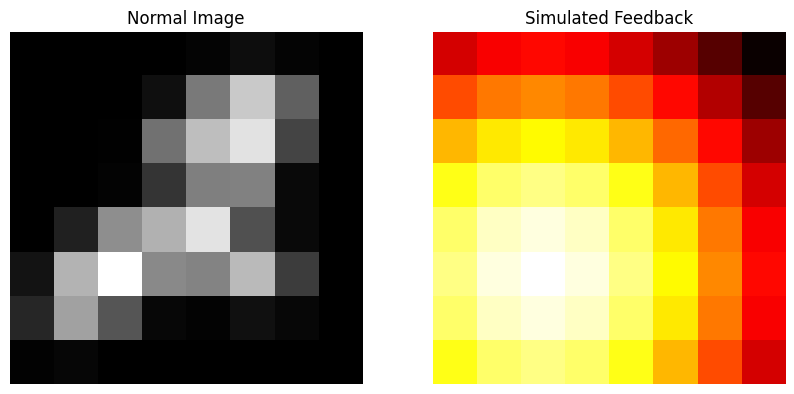

tensor(0.3679) tensor(1.)


In [2]:
# @title

import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

class MNISTEnvironment:
    def __init__(self, batch_size, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        dataset = MNIST('./data', train=True, download=True, transform=self.transform)
        self.loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape))

        x, y = np.meshgrid(np.arange(image_np.shape[1]), np.arange(image_np.shape[0]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'jet' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = MNISTEnvironment(batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())

In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()            

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):
    

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-08-16 17:34:03.433953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 17:34:03.434099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 17:34:03.598368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])
              
              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)                

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())

          correct = 0
          total = 0
          with torch.no_grad():
              for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])
                  
                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


# KAN width=16 grid=3

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


KAN_MNIST_0_1723829654:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.061690068861314735
 Train accuracy:  0.09381663113006397 | 


KAN_MNIST_0_1723829654:   1%|          | 1/100 [03:42<6:07:41, 222.84s/it]

 Test accuracy:  0.19

correct: 48 total: 469
loss: 0.05711852798838097
 Train accuracy:  0.1023454157782516 | 


KAN_MNIST_0_1723829654:   2%|▏         | 2/100 [08:51<7:25:57, 273.03s/it]

 Test accuracy:  0.3802

correct: 179 total: 469
loss: 0.05665052529654777
 Train accuracy:  0.3816631130063966 | 


KAN_MNIST_0_1723829654:   3%|▎         | 3/100 [14:42<8:19:34, 309.01s/it]

 Test accuracy:  0.4284

correct: 193 total: 469
loss: 0.05824315446272079
 Train accuracy:  0.4115138592750533 | 


KAN_MNIST_0_1723829654:   4%|▍         | 4/100 [20:33<8:40:52, 325.54s/it]

 Test accuracy:  0.4692

correct: 208 total: 469
loss: 0.06000916253942162
 Train accuracy:  0.44349680170575695 | 


KAN_MNIST_0_1723829654:   5%|▌         | 5/100 [26:25<8:50:35, 335.11s/it]

 Test accuracy:  0.4913

correct: 232 total: 469
loss: 0.06205162808680331
 Train accuracy:  0.4946695095948827 | 


KAN_MNIST_0_1723829654:   6%|▌         | 6/100 [32:17<8:53:45, 340.70s/it]

 Test accuracy:  0.4841

correct: 231 total: 469
loss: 0.06412391033349261
 Train accuracy:  0.4925373134328358 | 


KAN_MNIST_0_1723829654:   7%|▋         | 7/100 [38:08<8:53:37, 344.27s/it]

 Test accuracy:  0.5006

correct: 239 total: 469
loss: 0.06611114355133794
 Train accuracy:  0.509594882729211 | 


KAN_MNIST_0_1723829654:   8%|▊         | 8/100 [44:01<8:51:47, 346.82s/it]

 Test accuracy:  0.5115

correct: 239 total: 469
loss: 0.06674763519785551
 Train accuracy:  0.509594882729211 | 


KAN_MNIST_0_1723829654:   9%|▉         | 9/100 [49:54<8:48:56, 348.75s/it]

 Test accuracy:  0.513

correct: 255 total: 469
loss: 0.06875357341601142
 Train accuracy:  0.5437100213219617 | 


KAN_MNIST_0_1723829654:  10%|█         | 10/100 [55:47<8:45:22, 350.25s/it]

 Test accuracy:  0.5313

correct: 237 total: 469
loss: 0.07102859490461695
 Train accuracy:  0.5053304904051172 | 


KAN_MNIST_0_1723829654:  11%|█         | 11/100 [1:01:41<8:41:13, 351.38s/it]

 Test accuracy:  0.5358

correct: 241 total: 469
loss: 0.07206748296488831
 Train accuracy:  0.5138592750533049 | 


KAN_MNIST_0_1723829654:  12%|█▏        | 12/100 [1:07:35<8:36:32, 352.18s/it]

 Test accuracy:  0.5341

correct: 250 total: 469
loss: 0.07482038605918508
 Train accuracy:  0.5330490405117271 | 


KAN_MNIST_0_1723829654:  13%|█▎        | 13/100 [1:13:32<8:32:44, 353.62s/it]

 Test accuracy:  0.5454

correct: 241 total: 469
loss: 0.07588511764177128
 Train accuracy:  0.5138592750533049 | 


KAN_MNIST_0_1723829654:  14%|█▍        | 14/100 [1:19:29<8:28:21, 354.67s/it]

 Test accuracy:  0.5565

correct: 246 total: 469
loss: 0.07688604730532876
 Train accuracy:  0.5245202558635395 | 


KAN_MNIST_0_1723829654:  15%|█▌        | 15/100 [1:25:27<8:23:44, 355.59s/it]

 Test accuracy:  0.5575

correct: 268 total: 469
loss: 0.07812225210196427
 Train accuracy:  0.5714285714285714 | 


KAN_MNIST_0_1723829654:  16%|█▌        | 16/100 [1:31:26<8:19:06, 356.51s/it]

 Test accuracy:  0.5773

correct: 263 total: 469
loss: 0.07920833429230302
 Train accuracy:  0.5607675906183369 | 


KAN_MNIST_0_1723829654:  17%|█▋        | 17/100 [1:37:24<8:13:45, 356.94s/it]

 Test accuracy:  0.5699

correct: 265 total: 469
loss: 0.08063204859746799
 Train accuracy:  0.5650319829424307 | 


KAN_MNIST_0_1723829654:  18%|█▊        | 18/100 [1:43:23<8:08:56, 357.76s/it]

 Test accuracy:  0.5859

correct: 283 total: 469
loss: 0.08225935228915611
 Train accuracy:  0.603411513859275 | 


KAN_MNIST_0_1723829654:  19%|█▉        | 19/100 [1:49:26<8:04:56, 359.21s/it]

 Test accuracy:  0.5879

correct: 283 total: 469
loss: 0.08275687993208228
 Train accuracy:  0.603411513859275 | 


KAN_MNIST_0_1723829654:  20%|██        | 20/100 [1:55:27<7:59:34, 359.68s/it]

 Test accuracy:  0.5954

correct: 269 total: 469
loss: 0.08338246971114611
 Train accuracy:  0.5735607675906184 | 


KAN_MNIST_0_1723829654:  21%|██        | 21/100 [2:01:29<7:54:29, 360.37s/it]

 Test accuracy:  0.5981

correct: 288 total: 469
loss: 0.08402040775523766
 Train accuracy:  0.6140724946695096 | 


KAN_MNIST_0_1723829654:  22%|██▏       | 22/100 [2:07:33<7:49:54, 361.47s/it]

 Test accuracy:  0.6046

correct: 297 total: 469
loss: 0.08460919813179513
 Train accuracy:  0.6332622601279317 | 


KAN_MNIST_0_1723829654:  23%|██▎       | 23/100 [2:13:39<7:45:36, 362.81s/it]

 Test accuracy:  0.6055

correct: 279 total: 469
loss: 0.08547405814374688
 Train accuracy:  0.5948827292110874 | 


KAN_MNIST_0_1723829654:  24%|██▍       | 24/100 [2:19:45<7:40:54, 363.87s/it]

 Test accuracy:  0.6184

correct: 298 total: 469
loss: 0.08570986403140432
 Train accuracy:  0.6353944562899787 | 


KAN_MNIST_0_1723829654:  25%|██▌       | 25/100 [2:25:53<7:36:19, 365.06s/it]

 Test accuracy:  0.6263

correct: 296 total: 469
loss: 0.08619592434117027
 Train accuracy:  0.6311300639658849 | 


KAN_MNIST_0_1723829654:  26%|██▌       | 26/100 [2:33:36<8:06:44, 394.66s/it]

 Test accuracy:  0.6597

correct: 310 total: 469
loss: 0.10306956236169282
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1723829654:  27%|██▋       | 27/100 [2:39:49<7:52:04, 388.01s/it]

 Test accuracy:  0.6769

correct: 322 total: 469
loss: 0.10036791454373138
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1723829654:  28%|██▊       | 28/100 [2:46:08<7:42:21, 385.29s/it]

 Test accuracy:  0.675

correct: 314 total: 469
loss: 0.09972865545927588
 Train accuracy:  0.6695095948827292 | 


KAN_MNIST_0_1723829654:  29%|██▉       | 29/100 [2:52:21<7:31:40, 381.69s/it]

 Test accuracy:  0.6814

correct: 324 total: 469
loss: 0.10007553544443554
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1723829654:  30%|███       | 30/100 [2:58:35<7:22:28, 379.26s/it]

 Test accuracy:  0.6716

correct: 317 total: 469
loss: 0.09966400721624716
 Train accuracy:  0.67590618336887 | 


KAN_MNIST_0_1723829654:  31%|███       | 31/100 [3:04:47<7:13:51, 377.26s/it]

 Test accuracy:  0.6846

correct: 326 total: 469
loss: 0.10022325646966251
 Train accuracy:  0.6950959488272921 | 


KAN_MNIST_0_1723829654:  32%|███▏      | 32/100 [3:11:01<7:06:13, 376.07s/it]

 Test accuracy:  0.6887

correct: 334 total: 469
loss: 0.10067137875663701
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723829654:  33%|███▎      | 33/100 [3:17:13<6:58:38, 374.90s/it]

 Test accuracy:  0.6961

correct: 335 total: 469
loss: 0.09981569104484403
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723829654:  34%|███▍      | 34/100 [3:23:25<6:51:26, 374.04s/it]

 Test accuracy:  0.6818

correct: 316 total: 469
loss: 0.10064981344030864
 Train accuracy:  0.673773987206823 | 


KAN_MNIST_0_1723829654:  35%|███▌      | 35/100 [3:29:37<6:44:30, 373.39s/it]

 Test accuracy:  0.6947

correct: 327 total: 469
loss: 0.10023466113216078
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1723829654:  36%|███▌      | 36/100 [3:35:48<6:37:28, 372.63s/it]

 Test accuracy:  0.6897

correct: 305 total: 469
loss: 0.1016109510620774
 Train accuracy:  0.650319829424307 | 


KAN_MNIST_0_1723829654:  37%|███▋      | 37/100 [3:42:01<6:31:32, 372.89s/it]

 Test accuracy:  0.7001

correct: 347 total: 469
loss: 0.10205817988305203
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1723829654:  38%|███▊      | 38/100 [3:48:14<6:25:21, 372.93s/it]

 Test accuracy:  0.7044

correct: 332 total: 469
loss: 0.10150280413724212
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1723829654:  39%|███▉      | 39/100 [3:54:29<6:19:34, 373.35s/it]

 Test accuracy:  0.705

correct: 346 total: 469
loss: 0.10171639974882353
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1723829654:  40%|████      | 40/100 [4:00:42<6:13:27, 373.47s/it]

 Test accuracy:  0.7058

correct: 328 total: 469
loss: 0.10107848238843337
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1723829654:  41%|████      | 41/100 [4:06:58<6:07:55, 374.15s/it]

 Test accuracy:  0.7

correct: 330 total: 469
loss: 0.10244607633110811
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1723829654:  42%|████▏     | 42/100 [4:13:15<6:02:35, 375.10s/it]

 Test accuracy:  0.7207

correct: 336 total: 469
loss: 0.1022973800741279
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1723829654:  43%|████▎     | 43/100 [4:19:30<5:56:20, 375.10s/it]

 Test accuracy:  0.7163

correct: 341 total: 469
loss: 0.10242465813594587
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1723829654:  44%|████▍     | 44/100 [4:25:48<5:50:46, 375.82s/it]

 Test accuracy:  0.7095

correct: 356 total: 469
loss: 0.1027655572271042
 Train accuracy:  0.7590618336886994 | 


KAN_MNIST_0_1723829654:  45%|████▌     | 45/100 [4:32:06<5:45:06, 376.48s/it]

 Test accuracy:  0.7119

correct: 329 total: 469
loss: 0.1023208940747196
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1723829654:  46%|████▌     | 46/100 [4:38:24<5:39:18, 377.02s/it]

 Test accuracy:  0.7151

correct: 327 total: 469
loss: 0.1027778538146507
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1723829654:  47%|████▋     | 47/100 [4:44:43<5:33:26, 377.48s/it]

 Test accuracy:  0.7251

correct: 346 total: 469
loss: 0.10302270621633225
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1723829654:  48%|████▊     | 48/100 [4:51:03<5:27:57, 378.41s/it]

 Test accuracy:  0.7204

correct: 342 total: 469
loss: 0.10380215137434412
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1723829654:  49%|████▉     | 49/100 [4:57:25<5:22:28, 379.39s/it]

 Test accuracy:  0.718

correct: 333 total: 469
loss: 0.10378425188664435
 Train accuracy:  0.7100213219616205 | 


KAN_MNIST_0_1723829654:  50%|█████     | 50/100 [5:03:45<5:16:22, 379.65s/it]

 Test accuracy:  0.7257

correct: 355 total: 469
loss: 0.10341845629121195
 Train accuracy:  0.7569296375266524 | 


KAN_MNIST_0_1723829654:  51%|█████     | 51/100 [5:10:07<5:10:39, 380.41s/it]

 Test accuracy:  0.7283

correct: 321 total: 469
loss: 0.10310328173548428
 Train accuracy:  0.6844349680170576 | 


KAN_MNIST_0_1723829654:  52%|█████▏    | 52/100 [5:16:30<5:04:52, 381.10s/it]

 Test accuracy:  0.726

correct: 335 total: 469
loss: 0.10348963902703226
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723829654:  53%|█████▎    | 53/100 [5:22:53<4:58:56, 381.62s/it]

 Test accuracy:  0.7317

correct: 351 total: 469
loss: 0.10384176376023527
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1723829654:  54%|█████▍    | 54/100 [5:29:17<4:53:07, 382.34s/it]

 Test accuracy:  0.7276

correct: 335 total: 469
loss: 0.10473219785037072
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723829654:  55%|█████▌    | 55/100 [5:35:44<4:47:50, 383.78s/it]

 Test accuracy:  0.7296

correct: 346 total: 469
loss: 0.10428968326115151
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1723829654:  56%|█████▌    | 56/100 [5:42:09<4:41:39, 384.08s/it]

 Test accuracy:  0.7329

correct: 330 total: 469
loss: 0.10378368789834508
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1723829654:  57%|█████▋    | 57/100 [5:48:33<4:35:18, 384.14s/it]

 Test accuracy:  0.7317

correct: 348 total: 469
loss: 0.1051266357811021
 Train accuracy:  0.7420042643923241 | 


KAN_MNIST_0_1723829654:  58%|█████▊    | 58/100 [5:54:57<4:28:46, 383.96s/it]

 Test accuracy:  0.7276

correct: 349 total: 469
loss: 0.1038859413503838
 Train accuracy:  0.744136460554371 | 


KAN_MNIST_0_1723829654:  59%|█████▉    | 59/100 [6:01:20<4:22:08, 383.63s/it]

 Test accuracy:  0.739

correct: 334 total: 469
loss: 0.10518799074041818
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723829654:  60%|██████    | 60/100 [6:07:45<4:16:01, 384.05s/it]

 Test accuracy:  0.7383

correct: 337 total: 469
loss: 0.1047672266359014
 Train accuracy:  0.7185501066098081 | 


KAN_MNIST_0_1723829654:  61%|██████    | 61/100 [6:14:08<4:09:26, 383.76s/it]

 Test accuracy:  0.7398

correct: 334 total: 469
loss: 0.10464307551444975
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1723829654:  62%|██████▏   | 62/100 [6:20:32<4:03:05, 383.82s/it]

 Test accuracy:  0.7438

correct: 338 total: 469
loss: 0.10548488266750185
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1723829654:  63%|██████▎   | 63/100 [6:26:58<3:57:08, 384.56s/it]

 Test accuracy:  0.7325

correct: 351 total: 469
loss: 0.10500566593047653
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1723829654:  64%|██████▍   | 64/100 [6:33:26<3:51:25, 385.70s/it]

 Test accuracy:  0.7315

correct: 353 total: 469
loss: 0.10571937251891662
 Train accuracy:  0.7526652452025586 | 


KAN_MNIST_0_1723829654:  65%|██████▌   | 65/100 [6:39:57<3:45:46, 387.05s/it]

 Test accuracy:  0.7405

correct: 340 total: 469
loss: 0.10558879991838419
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1723829654:  66%|██████▌   | 66/100 [6:46:26<3:39:42, 387.71s/it]

 Test accuracy:  0.7349

correct: 347 total: 469
loss: 0.10549778381644535
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1723829654:  67%|██████▋   | 67/100 [6:52:52<3:32:54, 387.10s/it]

 Test accuracy:  0.7412

correct: 346 total: 469
loss: 0.1054093668074496
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1723829654:  68%|██████▊   | 68/100 [6:59:11<3:25:17, 384.91s/it]

 Test accuracy:  0.751

correct: 351 total: 469
loss: 0.10520561441366098
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1723829654:  69%|██████▉   | 69/100 [7:05:28<3:17:39, 382.57s/it]

 Test accuracy:  0.7368

correct: 352 total: 469
loss: 0.10540169282063747
 Train accuracy:  0.7505330490405118 | 


KAN_MNIST_0_1723829654:  70%|███████   | 70/100 [7:11:42<3:09:52, 379.76s/it]

 Test accuracy:  0.7393

correct: 360 total: 469
loss: 0.10583617712960823
 Train accuracy:  0.767590618336887 | 


KAN_MNIST_0_1723829654:  71%|███████   | 71/100 [7:17:58<3:03:01, 378.68s/it]

 Test accuracy:  0.746

correct: 329 total: 469
loss: 0.10525929673648338
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1723829654:  72%|███████▏  | 72/100 [7:24:11<2:56:00, 377.15s/it]

 Test accuracy:  0.7444

correct: 344 total: 469
loss: 0.10613988986465214
 Train accuracy:  0.7334754797441365 | 


KAN_MNIST_0_1723829654:  73%|███████▎  | 73/100 [7:30:28<2:49:37, 376.95s/it]

 Test accuracy:  0.74

correct: 339 total: 469
loss: 0.10628025367188809
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1723829654:  74%|███████▍  | 74/100 [7:36:46<2:43:32, 377.42s/it]

 Test accuracy:  0.7429

correct: 347 total: 469
loss: 0.10599518114569853
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1723829654:  75%|███████▌  | 75/100 [7:43:08<2:37:43, 378.54s/it]

 Test accuracy:  0.7425

correct: 335 total: 469
loss: 0.10715690415614704
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723829654:  76%|███████▌  | 76/100 [7:49:29<2:31:42, 379.28s/it]

 Test accuracy:  0.7506

correct: 361 total: 469
loss: 0.1060847851004936
 Train accuracy:  0.7697228144989339 | 


KAN_MNIST_0_1723829654:  77%|███████▋  | 77/100 [7:55:48<2:25:27, 379.47s/it]

 Test accuracy:  0.7482

correct: 356 total: 469
loss: 0.10569361880072144
 Train accuracy:  0.7590618336886994 | 


KAN_MNIST_0_1723829654:  78%|███████▊  | 78/100 [8:02:10<2:19:23, 380.14s/it]

 Test accuracy:  0.7501

correct: 341 total: 469
loss: 0.10615737650440192
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1723829654:  79%|███████▉  | 79/100 [8:08:35<2:13:31, 381.51s/it]

 Test accuracy:  0.7504

correct: 344 total: 469
loss: 0.10606469922482586
 Train accuracy:  0.7334754797441365 | 


KAN_MNIST_0_1723829654:  80%|████████  | 80/100 [8:14:57<2:07:15, 381.79s/it]

 Test accuracy:  0.7503

correct: 355 total: 469
loss: 0.10617669241260617
 Train accuracy:  0.7569296375266524 | 


KAN_MNIST_0_1723829654:  81%|████████  | 81/100 [8:21:15<2:00:30, 380.57s/it]

 Test accuracy:  0.7528

correct: 342 total: 469
loss: 0.10731468044682098
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1723829654:  82%|████████▏ | 82/100 [8:27:33<1:53:54, 379.68s/it]

 Test accuracy:  0.7417

correct: 360 total: 469
loss: 0.10607212773963079
 Train accuracy:  0.767590618336887 | 


KAN_MNIST_0_1723829654:  83%|████████▎ | 83/100 [8:33:51<1:47:29, 379.37s/it]

 Test accuracy:  0.7385

correct: 350 total: 469
loss: 0.10638851086213899
 Train accuracy:  0.746268656716418 | 


KAN_MNIST_0_1723829654:  84%|████████▍ | 84/100 [8:40:12<1:41:15, 379.71s/it]

 Test accuracy:  0.7515

correct: 356 total: 469
loss: 0.10603374531909601
 Train accuracy:  0.7590618336886994 | 


KAN_MNIST_0_1723829654:  85%|████████▌ | 85/100 [8:46:31<1:34:55, 379.67s/it]

 Test accuracy:  0.7475

correct: 349 total: 469
loss: 0.10673729760814578
 Train accuracy:  0.744136460554371 | 


KAN_MNIST_0_1723829654:  86%|████████▌ | 86/100 [8:52:52<1:28:38, 379.90s/it]

 Test accuracy:  0.7557

correct: 361 total: 469
loss: 0.10707257635621374
 Train accuracy:  0.7697228144989339 | 


KAN_MNIST_0_1723829654:  87%|████████▋ | 87/100 [8:59:13<1:22:22, 380.17s/it]

 Test accuracy:  0.7556

correct: 339 total: 469
loss: 0.10644049121182102
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1723829654:  88%|████████▊ | 88/100 [9:05:35<1:16:09, 380.76s/it]

 Test accuracy:  0.7612

correct: 355 total: 469
loss: 0.10689928379457897
 Train accuracy:  0.7569296375266524 | 


KAN_MNIST_0_1723829654:  89%|████████▉ | 89/100 [9:11:58<1:09:57, 381.56s/it]

 Test accuracy:  0.7523

correct: 331 total: 469
loss: 0.10674740240645053
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1723829654:  90%|█████████ | 90/100 [9:18:20<1:03:35, 381.58s/it]

 Test accuracy:  0.7505

correct: 335 total: 469
loss: 0.10679144482177966
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1723829654:  91%|█████████ | 91/100 [9:24:41<57:13, 381.46s/it]  

 Test accuracy:  0.7575

correct: 344 total: 469
loss: 0.10626988966010019
 Train accuracy:  0.7334754797441365 | 


KAN_MNIST_0_1723829654:  92%|█████████▏| 92/100 [9:31:02<50:51, 381.44s/it]

 Test accuracy:  0.7536

correct: 351 total: 469
loss: 0.10653875213759795
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1723829654:  93%|█████████▎| 93/100 [9:37:25<44:32, 381.72s/it]

 Test accuracy:  0.7478

correct: 360 total: 469
loss: 0.10664655579559838
 Train accuracy:  0.767590618336887 | 


KAN_MNIST_0_1723829654:  94%|█████████▍| 94/100 [9:43:49<38:15, 382.60s/it]

 Test accuracy:  0.7569

correct: 375 total: 469
loss: 0.10707067615632564
 Train accuracy:  0.7995735607675906 | 


KAN_MNIST_0_1723829654:  95%|█████████▌| 95/100 [9:50:13<31:54, 382.85s/it]

 Test accuracy:  0.754

correct: 345 total: 469
loss: 0.10658550316463909
 Train accuracy:  0.7356076759061834 | 


KAN_MNIST_0_1723829654:  96%|█████████▌| 96/100 [9:56:35<25:30, 382.62s/it]

 Test accuracy:  0.7543

correct: 352 total: 469
loss: 0.10673951962863458
 Train accuracy:  0.7505330490405118 | 


KAN_MNIST_0_1723829654:  97%|█████████▋| 97/100 [10:02:57<19:07, 382.59s/it]

 Test accuracy:  0.7576

correct: 356 total: 469
loss: 0.10652822955076628
 Train accuracy:  0.7590618336886994 | 


KAN_MNIST_0_1723829654:  98%|█████████▊| 98/100 [10:09:18<12:43, 381.86s/it]

 Test accuracy:  0.755

correct: 349 total: 469
loss: 0.1066973883746021
 Train accuracy:  0.744136460554371 | 


KAN_MNIST_0_1723829654:  99%|█████████▉| 99/100 [10:15:38<06:21, 381.40s/it]

 Test accuracy:  0.7568

correct: 346 total: 469
loss: 0.10768569103563264
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1723829654: 100%|██████████| 100/100 [10:21:59<00:00, 373.19s/it]

 Test accuracy:  0.7528


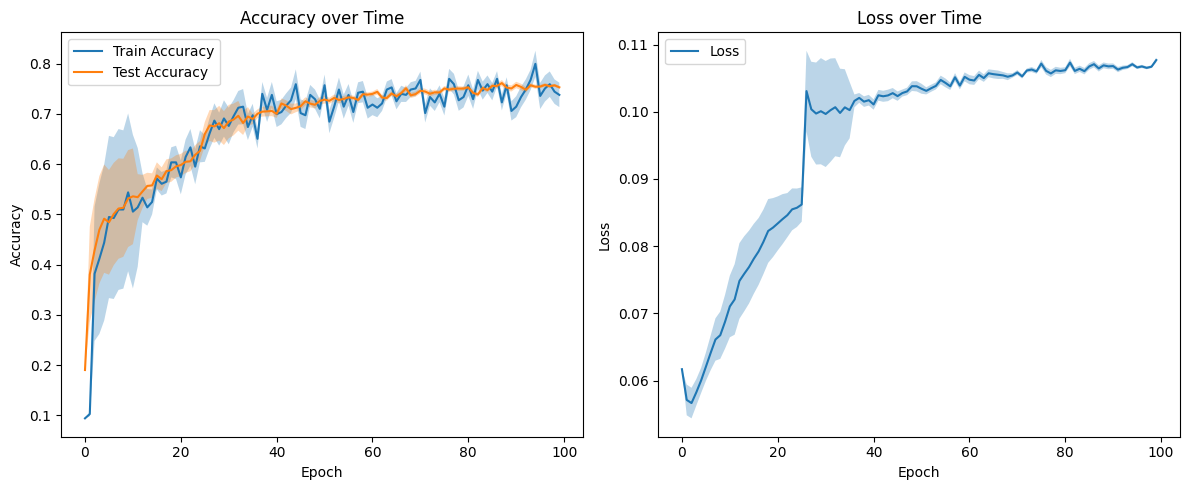

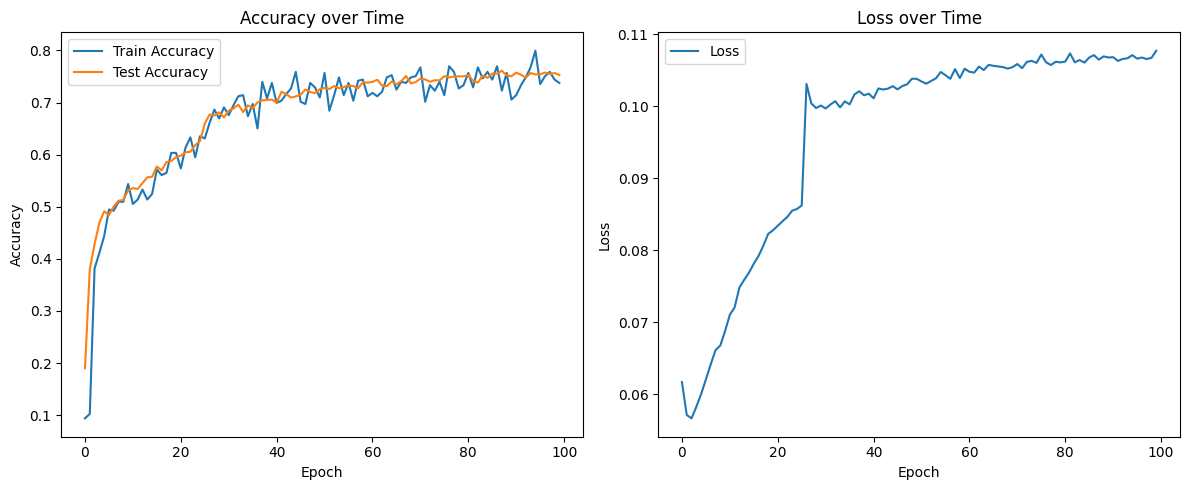

Final Train Accuracy: 0.74 ± 0.02
Final Test Accuracy: 0.75 ± 0.00


In [6]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 16,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

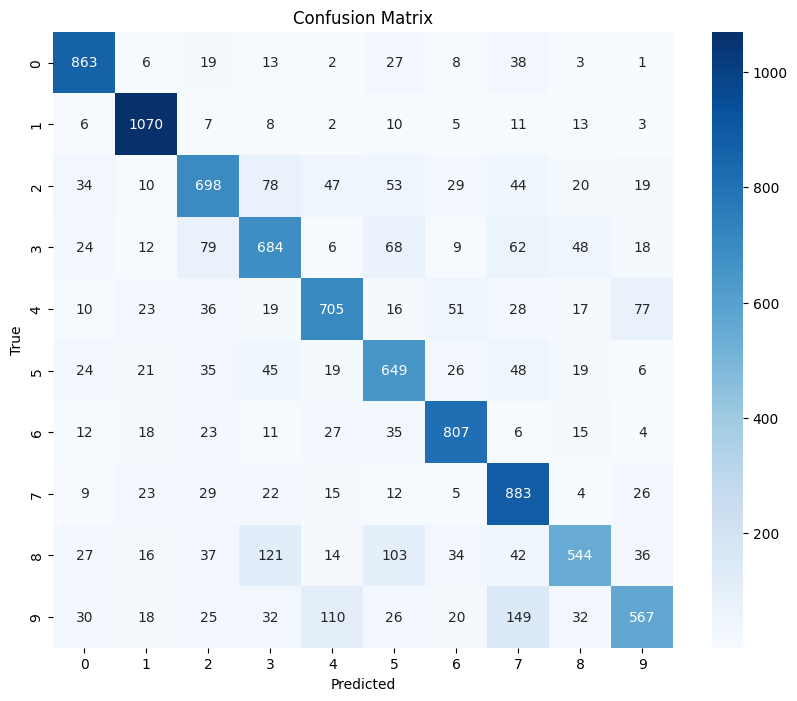

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
    for images, labels in DataLoader(MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       980
           1       0.88      0.94      0.91      1135
           2       0.71      0.68      0.69      1032
           3       0.66      0.68      0.67      1010
           4       0.74      0.72      0.73       982
           5       0.65      0.73      0.69       892
           6       0.81      0.84      0.83       958
           7       0.67      0.86      0.76      1028
           8       0.76      0.56      0.64       974
           9       0.75      0.56      0.64      1009

    accuracy                           0.75     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.75      0.74     10000



In [9]:
import gc
gc.collect()

27037